# Exploratory Data Analysis

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassPredictionError, ROCAUC

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

plt.rcParams['figure.dpi'] = 100

## Load Dataset

In [2]:
df = pd.read_csv("pendigits_txt.csv")
df.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


## Explore Data

In [3]:
def summary(df, pred=None):
    obs = df.shape[0]
    Types = df.dtypes
    Counts = df.apply(lambda x: x.count())
    Min = df.min()
    Max = df.max()
    Uniques = df.apply(lambda x: x.unique().shape[0])
    Nulls = df.apply(lambda x: x.isnull().sum())
    print('Data shape:', df.shape)

    if pred is None:
        cols = ['Types', 'Counts', 'Uniques', 'Nulls', 'Min', 'Max']
        str = pd.concat([Types, Counts, Uniques, Nulls, Min, Max], axis = 1, sort=True)

    str.columns = cols
    print('___________________________\nData Types:')
    print(str.Types.value_counts())
    print('___________________________')
    return str

summary(df)

Data shape: (10992, 17)
___________________________
Data Types:
int64    17
Name: Types, dtype: int64
___________________________


,Types,Counts,Uniques,Nulls,Min,Max
class,int64,10992,10,0,0,9
input1,int64,10992,101,0,0,100
input10,int64,10992,101,0,0,100
input11,int64,10992,101,0,0,100
input12,int64,10992,101,0,0,100
input13,int64,10992,101,0,0,100
input14,int64,10992,101,0,0,100
input15,int64,10992,101,0,0,100
input16,int64,10992,101,0,0,100
input2,int64,10992,96,0,0,100


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
input1,10992.0,38.814320,34.257783,0.0,6.0,32.0,65.0,100.0
input2,10992.0,85.120269,16.218571,0.0,76.0,89.0,100.0,100.0
input3,10992.0,40.605622,26.342984,0.0,20.0,40.0,58.0,100.0
input4,10992.0,83.774199,19.163646,0.0,72.0,91.0,100.0,100.0
input5,10992.0,49.770378,34.100515,0.0,18.0,53.0,78.0,100.0
input6,10992.0,65.573144,26.996688,0.0,49.0,71.0,86.0,100.0
input7,10992.0,51.220251,30.576881,0.0,28.0,53.5,74.0,100.0
input8,10992.0,44.498999,29.906104,0.0,23.0,43.0,64.0,100.0
input9,10992.0,56.868541,34.135530,0.0,29.0,60.0,89.0,100.0
input10,10992.0,33.695961,27.251548,0.0,7.0,33.0,54.0,100.0


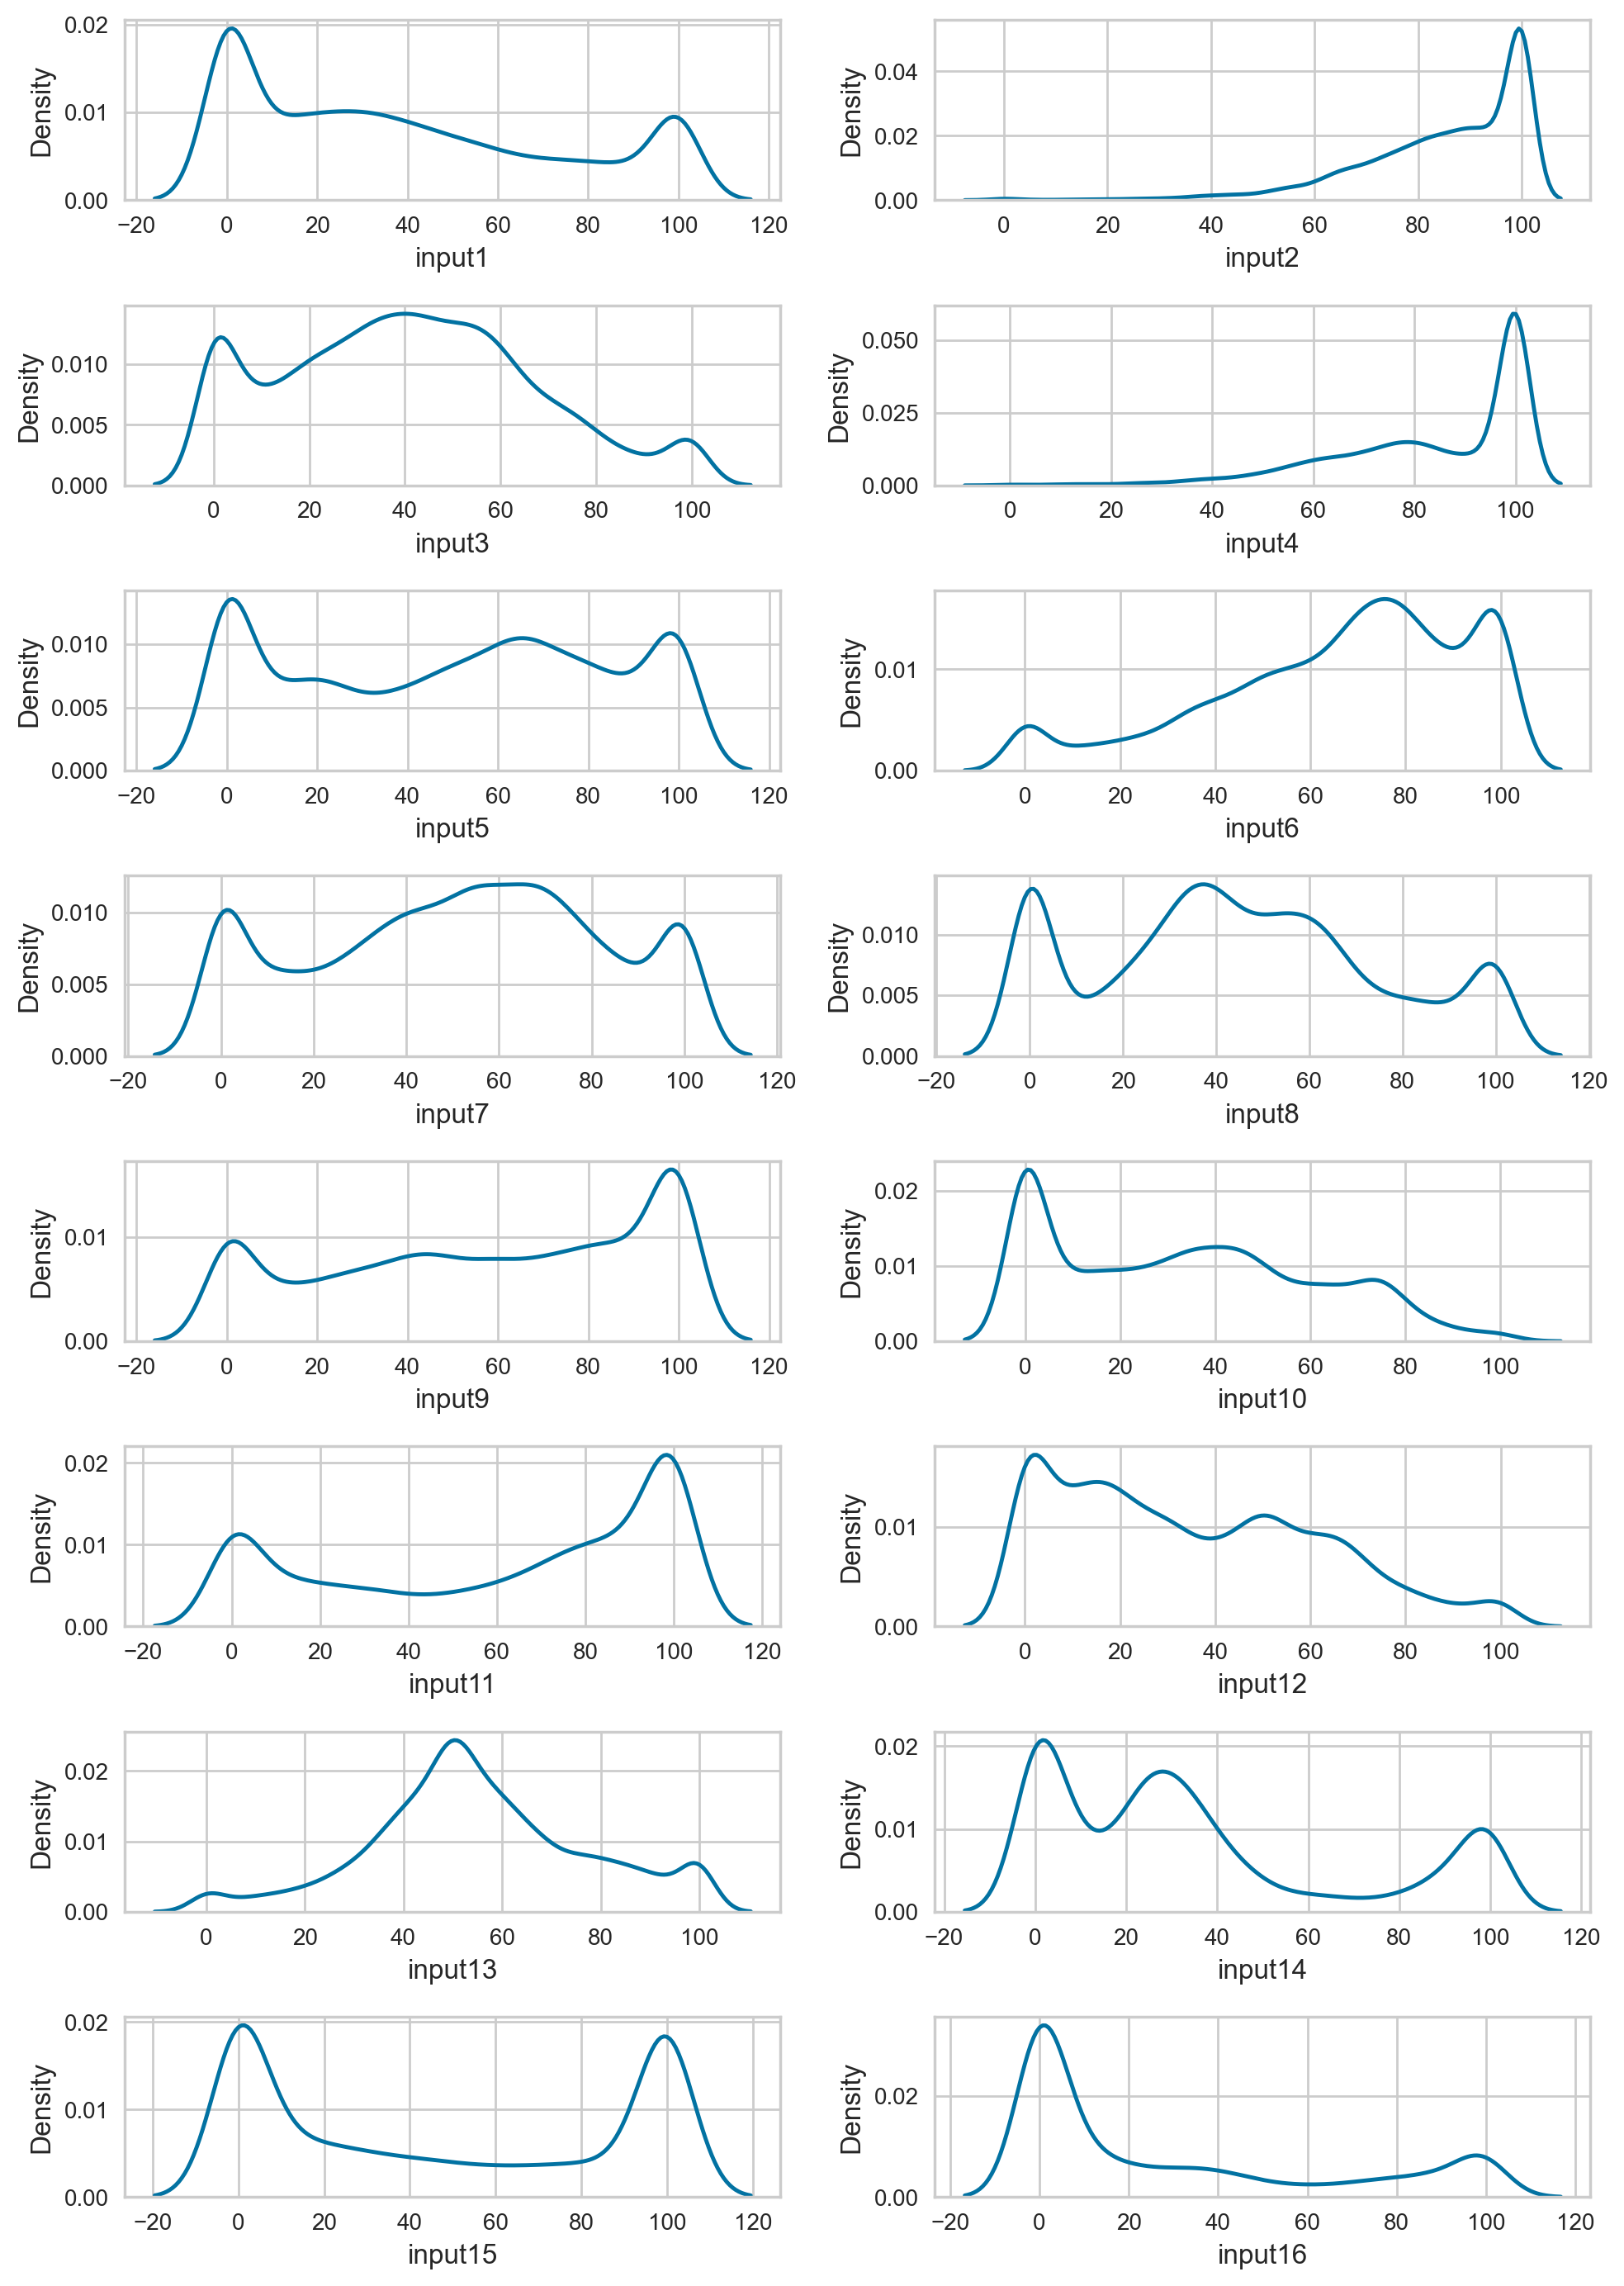

In [5]:
fig = plt.figure(figsize=(10,14), dpi=200)
for i, col in enumerate(df.columns[:-1]):
        plt.subplot(8,2,i+1)
        sns.kdeplot(df[col])
plt.tight_layout();

## Data Cleaning

### Detect Missing Values and Outliers

In [6]:
df.isnull().sum().any()

False

<Axes: >

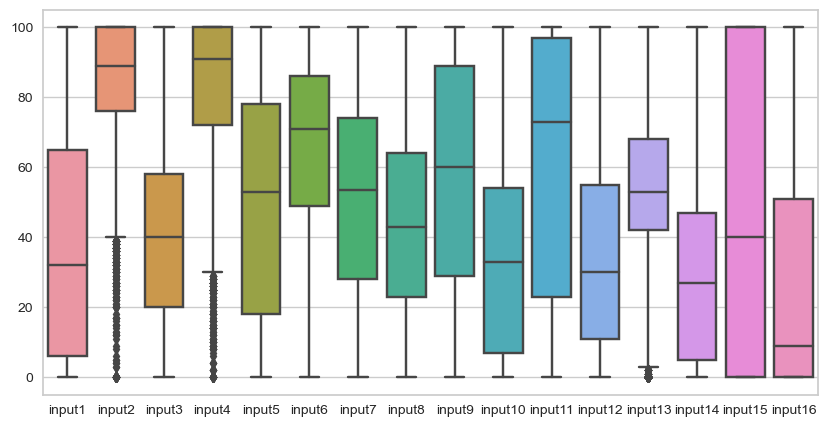

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df.drop("class", axis=1))

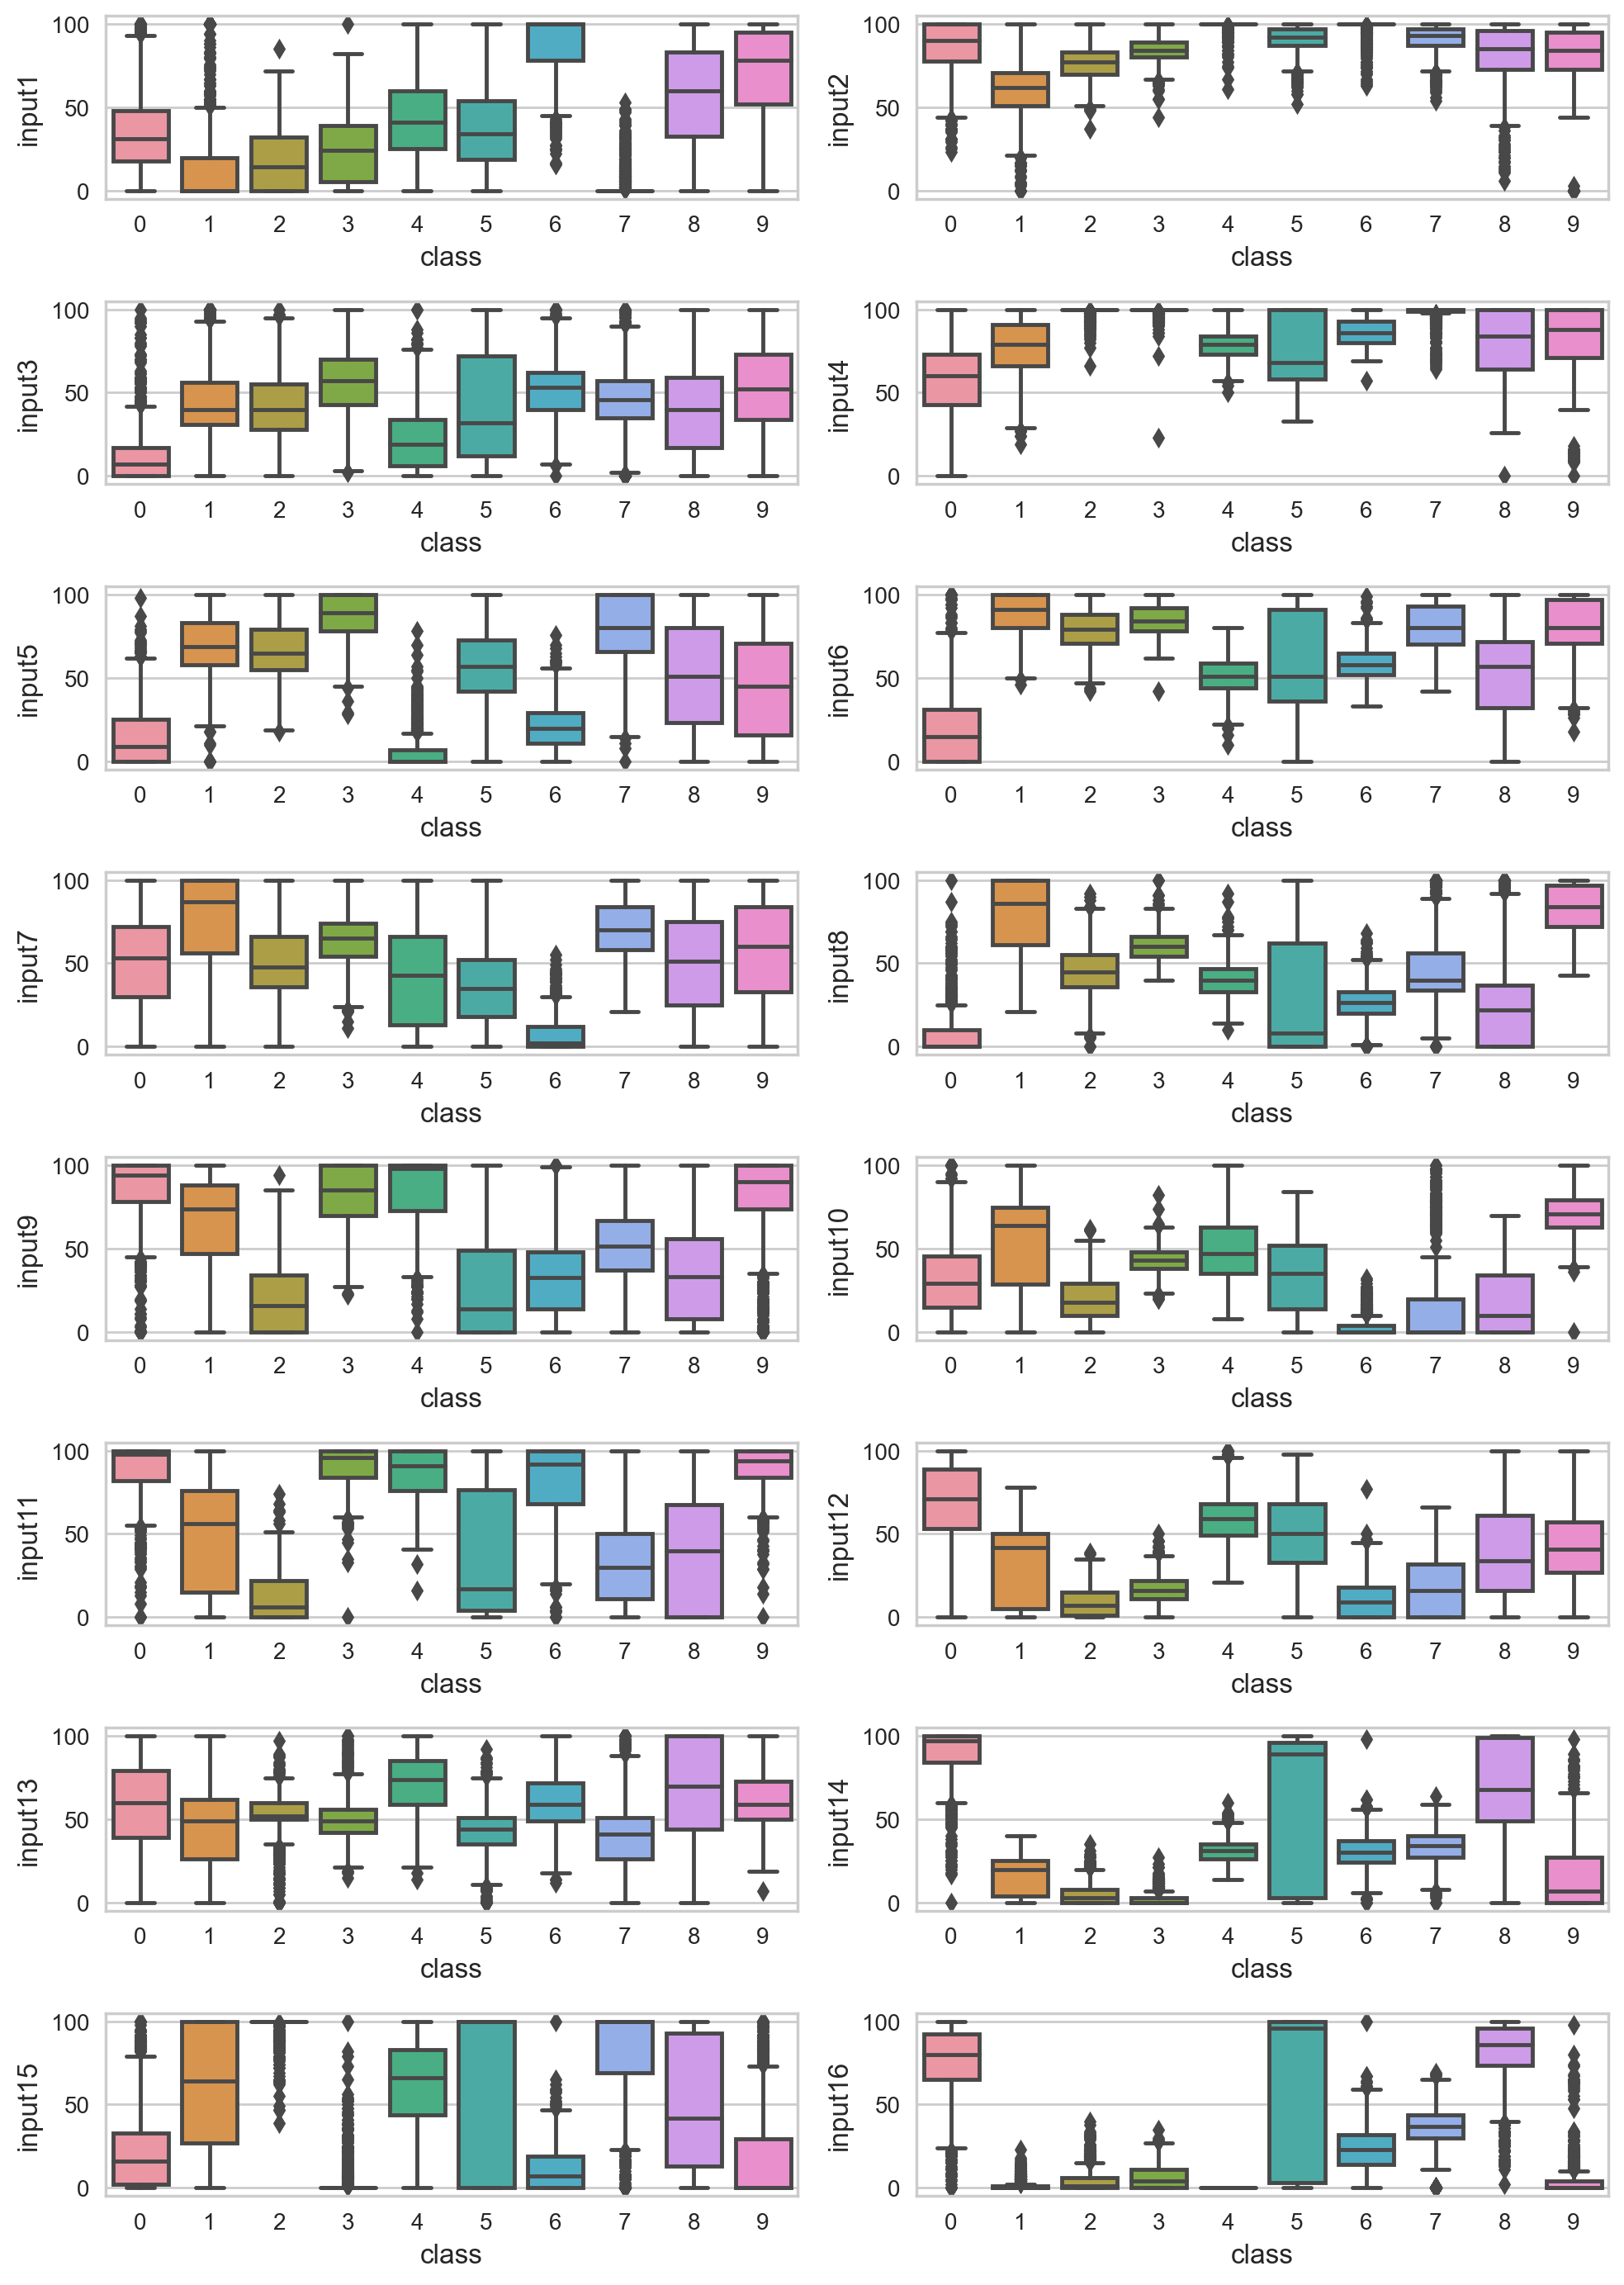

In [8]:
fig = plt.figure(figsize=(10,14), dpi=200)
for i, col in enumerate(df.columns[:-1]):
        plt.subplot(8,2,i+1)
        sns.boxplot(y= df[col], x = df["class"], data=df)
plt.tight_layout();

In [9]:
def detect_outliers(df, col_name,tukey=1.5):
    ''' 
    this function detects outliers based on 1.5 time IQR and
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(tukey*IQR)
    lower_limit = first_quartile-(tukey*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [10]:
threshold = 1.5
out_cols = []
for col in df.columns:
    print(
        f"{col}\nlower:{detect_outliers(df, col,threshold)[0]} \nupper:{detect_outliers(df, col,threshold)[1]}\
        \noutlier:{detect_outliers(df, col,threshold)[2]}\n*-*-*-*-*-*-*"
    )
    if detect_outliers(df, col,threshold)[2] > 0 :
        out_cols.append(col)
print(out_cols) 

input1
lower:-82.5 
upper:153.5        
outlier:0
*-*-*-*-*-*-*
input2
lower:40.0 
upper:136.0        
outlier:196
*-*-*-*-*-*-*
input3
lower:-37.0 
upper:115.0        
outlier:0
*-*-*-*-*-*-*
input4
lower:30.0 
upper:142.0        
outlier:153
*-*-*-*-*-*-*
input5
lower:-72.0 
upper:168.0        
outlier:0
*-*-*-*-*-*-*
input6
lower:-6.5 
upper:141.5        
outlier:0
*-*-*-*-*-*-*
input7
lower:-41.0 
upper:143.0        
outlier:0
*-*-*-*-*-*-*
input8
lower:-38.5 
upper:125.5        
outlier:0
*-*-*-*-*-*-*
input9
lower:-61.0 
upper:179.0        
outlier:0
*-*-*-*-*-*-*
input10
lower:-63.5 
upper:124.5        
outlier:0
*-*-*-*-*-*-*
input11
lower:-88.0 
upper:208.0        
outlier:0
*-*-*-*-*-*-*
input12
lower:-55.0 
upper:121.0        
outlier:0
*-*-*-*-*-*-*
input13
lower:3.0 
upper:107.0        
outlier:208
*-*-*-*-*-*-*
input14
lower:-58.0 
upper:110.0        
outlier:0
*-*-*-*-*-*-*
input15
lower:-150.0 
upper:250.0        
outlier:0
*-*-*-*-*-*-*
input16
lower:-76.5 
upper:127.5

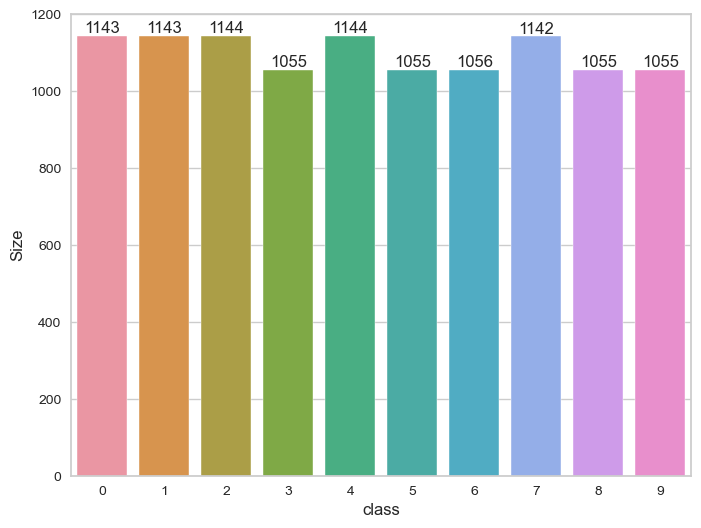

In [16]:
class_digit = df.groupby('class').size()
class_label = pd.DataFrame(class_digit,columns = ['Size'])
plt.figure(figsize = (8,6))
ax= sns.barplot(x = class_label.index, y = 'Size', data = class_label)
plt.bar_label(ax.containers[0]);

## Correlation 

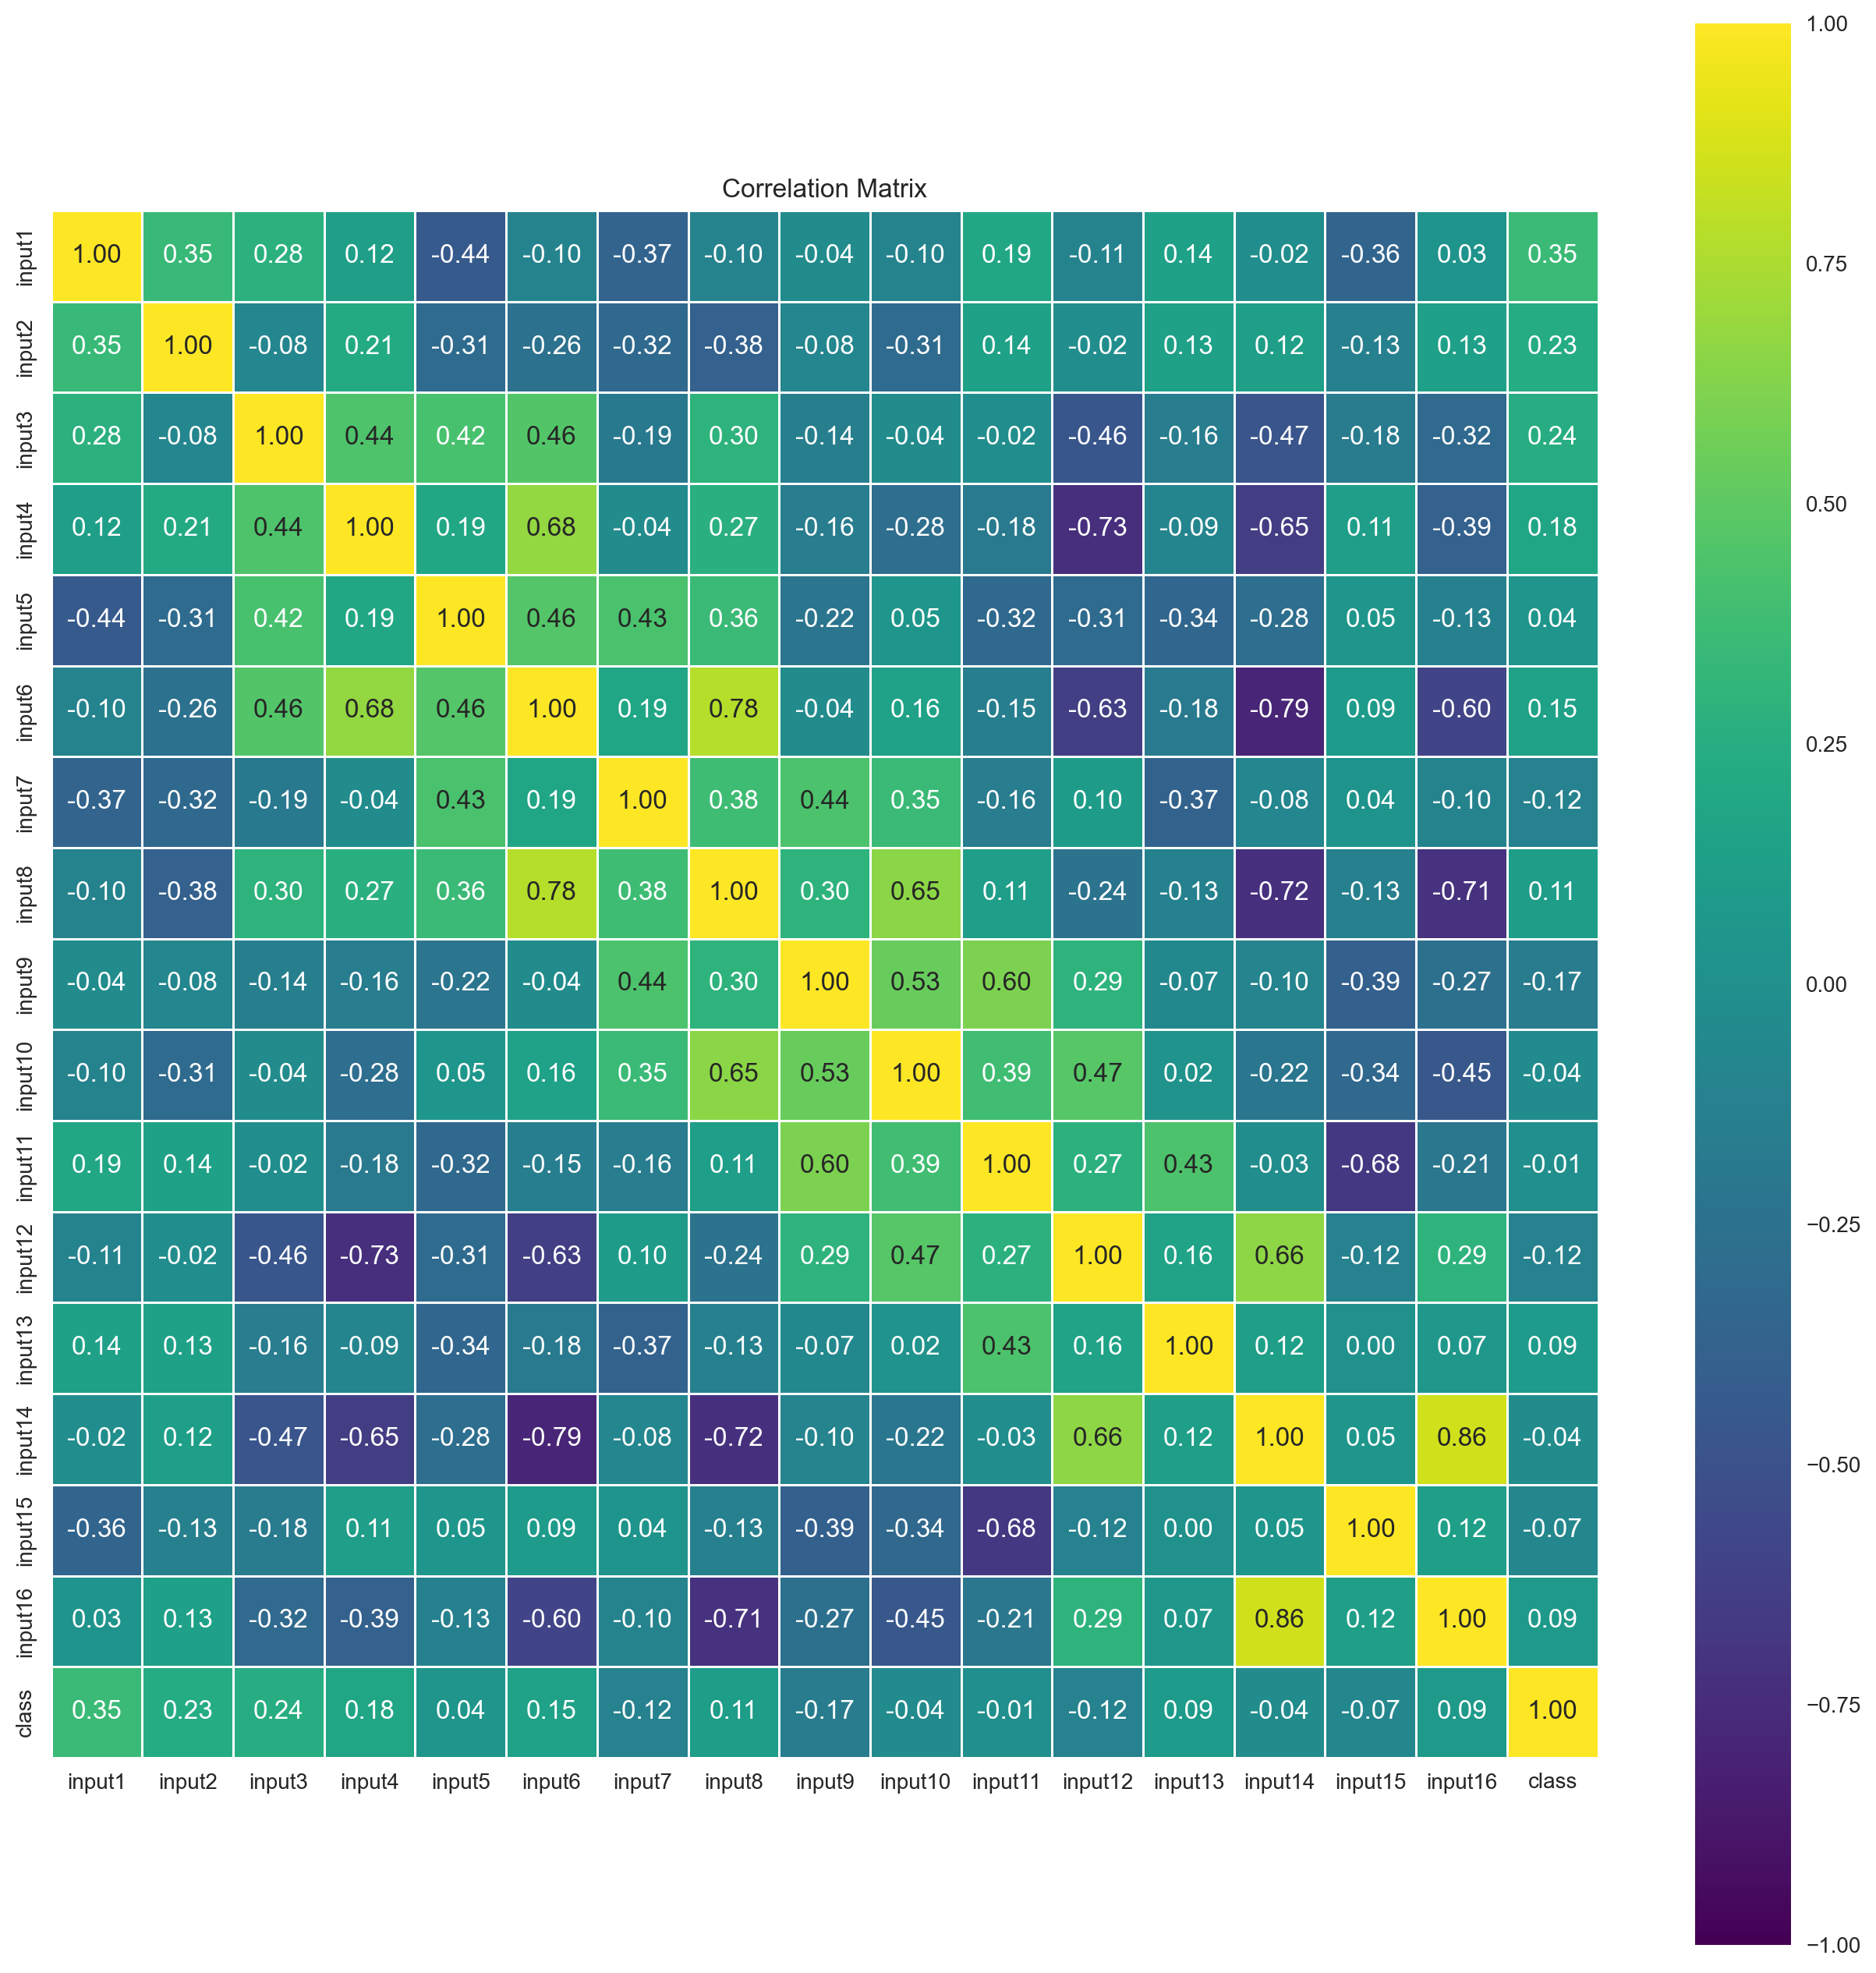

In [14]:
corr_matrix = df.corr()

plt.figure(figsize=(16, 16), dpi=200)
sns.heatmap(corr_matrix,square=True, annot=True, fmt=".2f", annot_kws={"size": 12}, linewidths=.5, vmin=-1, vmax=1, cmap='viridis')
plt.title("Correlation Matrix")

plt.show();

In [15]:
df.to_csv("handdigit_EDA.csv", index = False)

# Multi-class Classification

In [17]:
df = pd.read_csv("handdigit_EDA.csv")

In [18]:
df.head()

,input1,input2,input3,input4,input5,input6,input7,input8,input9,input10,input11,input12,input13,input14,input15,input16,class
0,47,100,27,81,57,37,26,0,0,23,56,53,100,90,40,98,8
1,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
2,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
3,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
4,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1


In [19]:
X = df.drop("class", axis = 1)
y = df["class"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

In [21]:
scaler = MinMaxScaler() 

In [22]:
modelSVM =  SVC(kernel="rbf")

In [23]:
from sklearn.pipeline  import Pipeline

modelSVM = Pipeline([("scaler",scaler),("SVM",modelSVM)])

In [24]:
modelSVM.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('SVM', SVC())])

In [25]:
y_pred_test = modelSVM.predict(X_test)
y_pred_train = modelSVM.predict(X_train)

In [31]:
SVM_accuracy_test = accuracy_score(y_test, y_pred_test)
SVM_accuracy_train = accuracy_score(y_train, y_pred_train)

svm_f1_test = f1_score(y_test, y_pred_test, average='micro')
svm_f1_train = f1_score(y_train, y_pred_train, average='micro')

SVM_accuracy_test, SVM_accuracy_train, svm_f1_test, svm_f1_train

(0.9894468704512372,
 0.9959970887918487,
 0.9894468704512372,
 0.9959970887918487)

In [32]:
print("TEST CM\n" , confusion_matrix(y_test, y_pred_test))
print("-*"*30)
print("TRAIN CM \n", confusion_matrix(y_train, y_pred_train))

print("TEST REPORT \n", classification_report(y_test, y_pred_test, digits= 3))
print("-*"*30)
print("TRAIN REPORT \n", classification_report(y_train, y_pred_train, digits= 3))


TEST CM
 [[270   0   0   0   0   0   0   0   2   0]
 [  0 283   7   0   1   0   0   1   0   0]
 [  0   1 293   0   0   0   0   0   0   0]
 [  0   0   0 277   0   0   0   0   0   1]
 [  0   0   0   0 288   2   0   0   0   0]
 [  0   0   0   3   0 263   0   0   0   1]
 [  0   0   0   0   0   0 264   0   0   0]
 [  0   2   2   0   0   0   0 265   0   0]
 [  0   0   0   0   0   1   0   0 255   0]
 [  0   1   0   0   0   0   0   3   1 261]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TRAIN CM 
 [[869   1   0   0   0   0   1   0   0   0]
 [  0 841   4   5   0   0   0   1   0   0]
 [  0   3 846   0   0   0   0   1   0   0]
 [  0   1   2 771   0   1   0   1   0   1]
 [  0   0   0   0 851   2   0   1   0   0]
 [  0   0   0   2   0 783   0   0   1   2]
 [  0   0   0   0   0   1 791   0   0   0]
 [  0   0   0   0   0   0   0 873   0   0]
 [  0   0   0   0   0   0   0   1 798   0]
 [  0   1   0   0   0   0   0   0   0 788]]
TEST REPORT 
               precision    recall  f1-score

### SVC GridsearchCV

In [33]:
param_grid = {'SVM__C':np.linspace(1, 1.3, 10),
              'SVM__gamma':["scale", "auto"]
             }

In [34]:
model = Pipeline([("scaler",scaler),("SVM", SVC(kernel="rbf"))]) 

svm_model_grid = GridSearchCV(model,
                              param_grid,
                              verbose=2,
                              scoring="accuracy",
                              n_jobs=-1)

svm_model_grid.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('SVM', SVC())]),
             n_jobs=-1,
             param_grid={'SVM__C': array([1.        , 1.03333333, 1.06666667, 1.1       , 1.13333333,
       1.16666667, 1.2       , 1.23333333, 1.26666667, 1.3       ]),
                         'SVM__gamma': ['scale', 'auto']},
             scoring='accuracy', verbose=2)

In [35]:
svm_model_grid.best_params_

{'SVM__C': 1.1666666666666667, 'SVM__gamma': 'scale'}

[CV] END .......................SVM__C=1.0, SVM__gamma=scale; total time=   1.1s
[CV] END ........SVM__C=1.0333333333333334, SVM__gamma=scale; total time=   1.1s
[CV] END .........SVM__C=1.0333333333333334, SVM__gamma=auto; total time=   2.5s
[CV] END .........SVM__C=1.0666666666666667, SVM__gamma=auto; total time=   2.4s
[CV] END ........................SVM__C=1.1, SVM__gamma=auto; total time=   2.7s
[CV] END ........SVM__C=1.1666666666666667, SVM__gamma=scale; total time=   1.1s
[CV] END ........SVM__C=1.1666666666666667, SVM__gamma=scale; total time=   1.2s
[CV] END .........SVM__C=1.1666666666666667, SVM__gamma=auto; total time=   2.5s
[CV] END ........SVM__C=1.2333333333333334, SVM__gamma=scale; total time=   1.2s
[CV] END .........SVM__C=1.2333333333333334, SVM__gamma=auto; total time=   2.5s
[CV] END .........SVM__C=1.2666666666666666, SVM__gamma=auto; total time=   2.3s
[CV] END ........................SVM__C=1.3, SVM__gamma=auto; total time=   1.8s
[CV] END ...................

[CV] END ........................SVM__C=1.0, SVM__gamma=auto; total time=   2.5s
[CV] END .........SVM__C=1.0333333333333334, SVM__gamma=auto; total time=   2.4s
[CV] END .........SVM__C=1.0666666666666667, SVM__gamma=auto; total time=   2.3s
[CV] END ........................SVM__C=1.1, SVM__gamma=auto; total time=   2.7s
[CV] END ........SVM__C=1.1666666666666667, SVM__gamma=scale; total time=   1.2s
[CV] END ........SVM__C=1.1666666666666667, SVM__gamma=scale; total time=   1.2s
[CV] END .........SVM__C=1.1666666666666667, SVM__gamma=auto; total time=   2.5s
[CV] END ........................SVM__C=1.2, SVM__gamma=auto; total time=   2.5s
[CV] END ........SVM__C=1.2666666666666666, SVM__gamma=scale; total time=   1.1s
[CV] END .........SVM__C=1.2666666666666666, SVM__gamma=auto; total time=   2.2s
[CV] END ........................SVM__C=1.3, SVM__gamma=auto; total time=   1.9s
[CV] END .......................SVM__C=1.0, SVM__gamma=scale; total time=   1.0s
[CV] END ...................

In [36]:
svm_model_grid.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()), ('SVM', SVC(C=1.1666666666666667))])

In [37]:
y_pred_test = svm_model_grid.predict(X_test)
y_pred_train = svm_model_grid.predict(X_train)

In [38]:
SVM_accuracy_test = accuracy_score(y_test, y_pred_test)
SVM_accuracy_train = accuracy_score(y_train, y_pred_train)

svm_f1_test = f1_score(y_test, y_pred_test, average='macro')
svm_f1_train = f1_score(y_train, y_pred_train, average='macro')

SVM_accuracy_test, SVM_accuracy_train, svm_f1_test, svm_f1_train

(0.9898107714701602,
 0.9964822901504125,
 0.9899493981509441,
 0.9964616881331348)

In [39]:
print("TEST CM\n" , confusion_matrix(y_test, y_pred_test))
print("-*"*30)
print("TRAIN CM \n", confusion_matrix(y_train, y_pred_train))

print("TEST REPORT \n", classification_report(y_test, y_pred_test, digits= 3))
print("-*"*30)
print("TRAIN REPORT \n", classification_report(y_train, y_pred_train, digits= 3))

TEST CM
 [[271   0   0   0   0   0   0   0   1   0]
 [  0 283   7   0   1   0   0   1   0   0]
 [  0   1 293   0   0   0   0   0   0   0]
 [  0   0   0 277   0   0   0   0   0   1]
 [  0   0   0   0 288   2   0   0   0   0]
 [  0   0   0   3   0 263   0   0   0   1]
 [  0   0   0   0   0   0 264   0   0   0]
 [  0   2   2   0   0   0   0 265   0   0]
 [  0   0   0   0   0   1   0   0 255   0]
 [  0   1   0   0   0   0   0   3   1 261]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TRAIN CM 
 [[869   1   0   0   0   0   1   0   0   0]
 [  0 842   4   4   0   0   0   1   0   0]
 [  0   1 848   0   0   0   0   1   0   0]
 [  0   1   2 771   0   1   0   1   0   1]
 [  0   0   0   0 852   1   0   1   0   0]
 [  0   0   0   2   0 783   0   0   1   2]
 [  0   0   0   0   0   1 791   0   0   0]
 [  0   0   0   0   0   0   0 873   0   0]
 [  0   0   0   0   0   0   0   1 798   0]
 [  0   1   0   0   0   0   0   0   0 788]]
TEST REPORT 
               precision    recall  f1-score

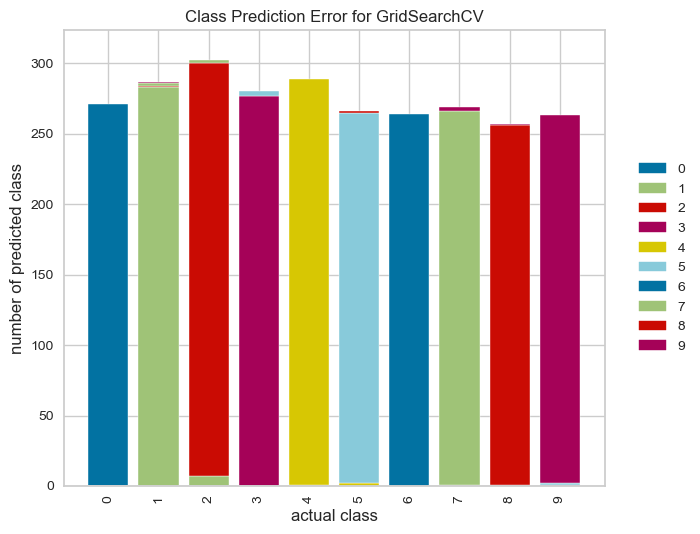

<Axes: title={'center': 'Class Prediction Error for GridSearchCV'}, xlabel='actual class', ylabel='number of predicted class'>

In [40]:
visualizer = ClassPredictionError(svm_model_grid)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

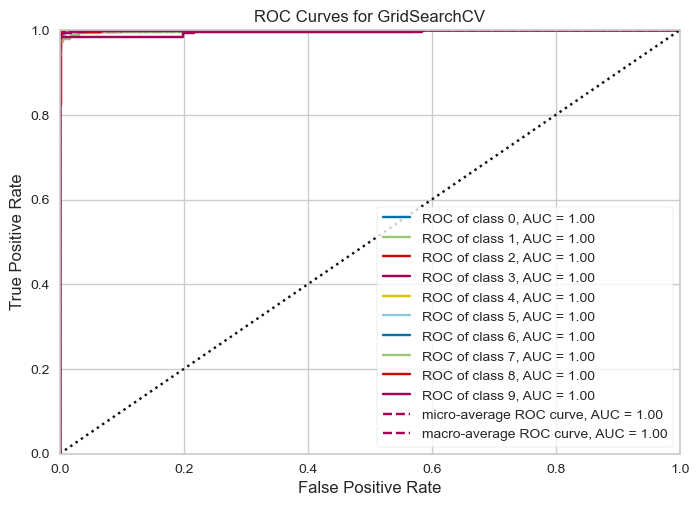

In [41]:
visualizer = ROCAUC(svm_model_grid, classes=[str(i) for i in range(10)])

visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show();                      

## Random Forest Classifier


In [42]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
y_pred_test = rfc.predict(X_test)
y_pred_train = rfc.predict(X_train)

In [44]:
rfc_accuracy_test = accuracy_score(y_test, y_pred_test)
rfc_accuracy_train = accuracy_score(y_train, y_pred_train)

rfc_f1_test = f1_score(y_test, y_pred_test, average='macro')
rfc_f1_train = f1_score(y_train, y_pred_train, average='macro')

rfc_accuracy_test, rfc_accuracy_train, rfc_f1_test, rfc_f1_train

(0.9836244541484717, 1.0, 0.9839993304425485, 1.0)

In [45]:
print("TEST REPORT")
print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test, digits = 3))


print("\n"*3, "-*"*30)
print("TRAIN REPORT")
print(confusion_matrix(y_train, y_pred_train))
print(classification_report(y_train, y_pred_train, digits = 3))

TEST REPORT
[[267   0   0   0   0   0   0   0   5   0]
 [  0 274  16   0   1   0   0   1   0   0]
 [  0   4 289   0   0   0   0   1   0   0]
 [  0   1   0 277   0   0   0   0   0   0]
 [  0   0   0   0 290   0   0   0   0   0]
 [  0   0   0   3   0 262   0   0   0   2]
 [  0   1   0   0   0   0 263   0   0   0]
 [  0   3   2   0   0   0   0 264   0   0]
 [  0   0   0   0   0   1   0   0 255   0]
 [  0   0   0   1   0   0   0   2   1 262]]
              precision    recall  f1-score   support

           0      1.000     0.982     0.991       272
           1      0.968     0.938     0.953       292
           2      0.941     0.983     0.962       294
           3      0.986     0.996     0.991       278
           4      0.997     1.000     0.998       290
           5      0.996     0.981     0.989       267
           6      1.000     0.996     0.998       264
           7      0.985     0.981     0.983       269
           8      0.977     0.996     0.986       256
           9    

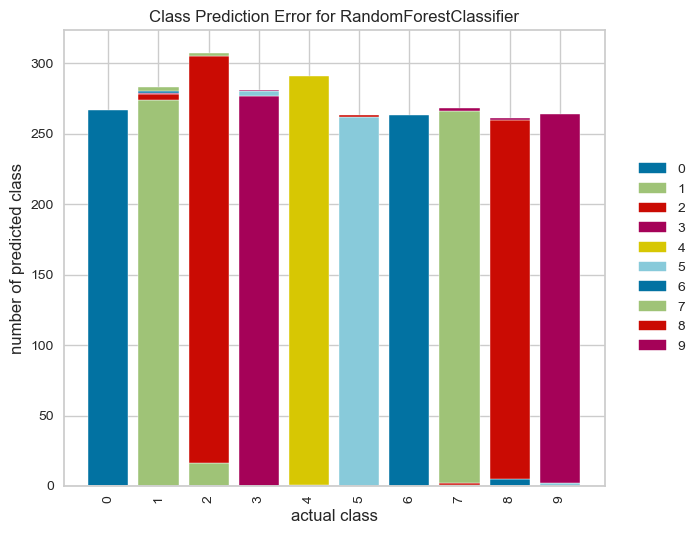

<Axes: title={'center': 'Class Prediction Error for RandomForestClassifier'}, xlabel='actual class', ylabel='number of predicted class'>

In [46]:
visualizer = ClassPredictionError(rfc)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

### RF GridsearchCV

In [53]:
param_grid = {
             'criterion': ["entropy","gini"],
             'max_depth':[5,10],
             'max_features':['auto', 0.8],
             'max_leaf_nodes': [180,200],
             'n_estimators':[50,100],
             }

In [54]:
rf_model = RandomForestClassifier()
rf_grid_model = GridSearchCV(rf_model,
                             param_grid,
                             verbose=2,
                             scoring="accuracy",
                             n_jobs=-1)

rf_grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/zahid/anaconda3/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is 

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'], 'max_depth': [5, 10],
                         'max_features': ['auto', 0.8],
                         'max_leaf_nodes': [180, 200],
                         'n_estimators': [50, 100]},
             scoring='accuracy', verbose=2)

In [55]:
rf_grid_model.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 0.8,
 'max_leaf_nodes': 180,
 'n_estimators': 100}

In [56]:
y_pred_test = rf_grid_model.predict(X_test)
y_pred_train = rf_grid_model.predict(X_train)

In [61]:
rfc_accuracy_test = accuracy_score(y_test, y_pred_test)
rfc_accuracy_train = accuracy_score(y_train, y_pred_train)

rfc_f1_test = f1_score(y_test, y_pred_test, average='micro')
rfc_f1_train = f1_score(y_train, y_pred_train, average='micro')

rfc_accuracy_test, rfc_accuracy_train, rfc_f1_test, rfc_f1_train

(0.9810771470160117,
 0.9990295972828724,
 0.9810771470160117,
 0.9990295972828724)

In [62]:
print("TEST CM\n" , confusion_matrix(y_test, y_pred_test))
print("-*"*30)
print("TRAIN CM \n", confusion_matrix(y_train, y_pred_train))
print("-*"*30)
print("TEST REPORT \n", classification_report(y_test, y_pred_test, digits= 3))
print("-*"*30)
print("TRAIN REPORT \n", classification_report(y_train, y_pred_train, digits= 3))

TEST CM
 [[269   0   0   0   0   0   0   0   3   0]
 [  0 273  17   0   1   0   0   1   0   0]
 [  0   3 289   0   0   0   0   2   0   0]
 [  0   2   0 275   0   1   0   0   0   0]
 [  0   0   0   0 290   0   0   0   0   0]
 [  0   0   0   4   0 260   0   0   0   3]
 [  0   0   0   0   0   0 264   0   0   0]
 [  0   5   2   0   0   0   0 261   1   0]
 [  2   0   0   0   0   0   0   0 254   0]
 [  0   1   0   1   0   0   0   2   1 261]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
TRAIN CM 
 [[871   0   0   0   0   0   0   0   0   0]
 [  0 847   1   3   0   0   0   0   0   0]
 [  0   0 850   0   0   0   0   0   0   0]
 [  0   1   1 775   0   0   0   0   0   0]
 [  0   0   0   0 854   0   0   0   0   0]
 [  0   0   0   1   0 787   0   0   0   0]
 [  0   0   0   0   0   1 791   0   0   0]
 [  0   0   0   0   0   0   0 873   0   0]
 [  0   0   0   0   0   0   0   0 799   0]
 [  0   0   0   0   0   0   0   0   0 789]]
-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

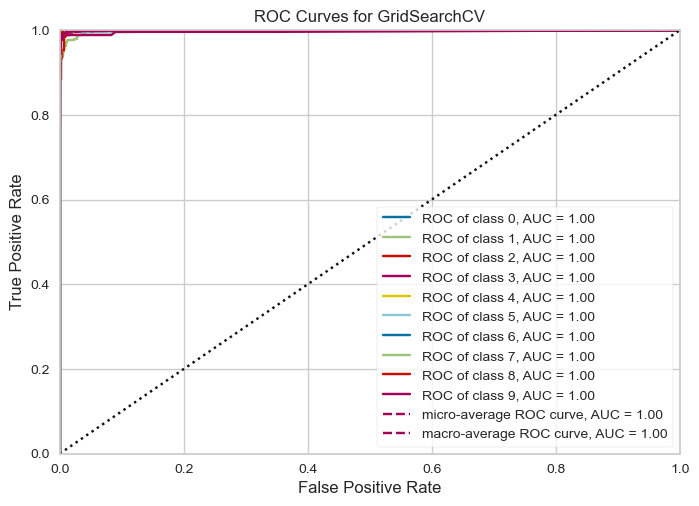

<Axes: title={'center': 'ROC Curves for GridSearchCV'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [63]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf_grid_model, classes=[str(i) for i in range(10)])

visualizer.fit(X_train, y_train)       
visualizer.score(X_test, y_test)      
visualizer.show()                

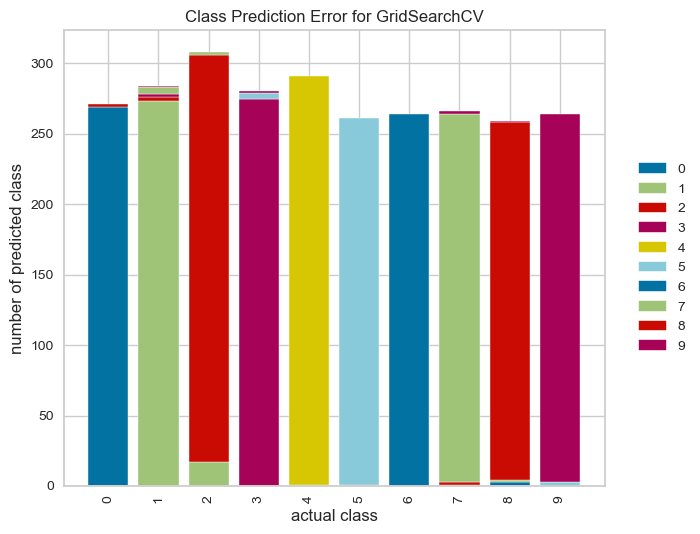

<Axes: title={'center': 'Class Prediction Error for GridSearchCV'}, xlabel='actual class', ylabel='number of predicted class'>

In [60]:
visualizer = ClassPredictionError(rf_grid_model)

# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)

# Evaluate the model on the test data
visualizer.score(X_test, y_test)

# Draw visualization
visualizer.show()

# Compare The Models

## Accuracy Comparison

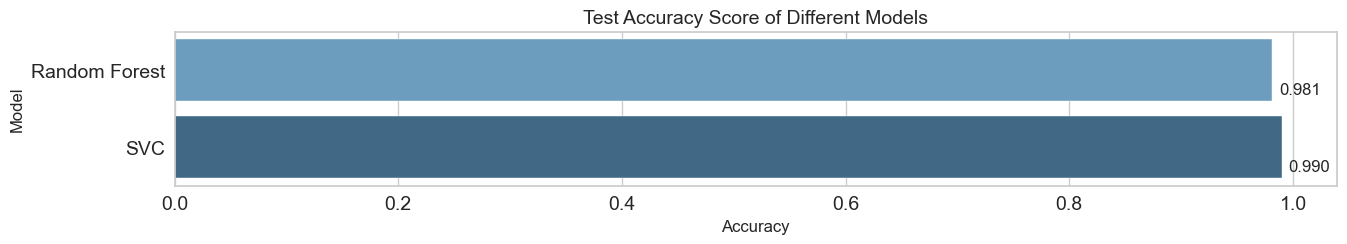

In [64]:
compare = pd.DataFrame({"Model": ["SVC", "Random Forest"],
                        "Accuracy": [SVM_accuracy_test, rfc_accuracy_test]})

compare = compare.sort_values(by="Accuracy", ascending=True)

plt.figure(figsize=(15,2))
ax = sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + 0.9),
                xytext=(5, 10), textcoords='offset points')

plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Test Accuracy Score of Different Models", size=14);

## F1 Score Comparison


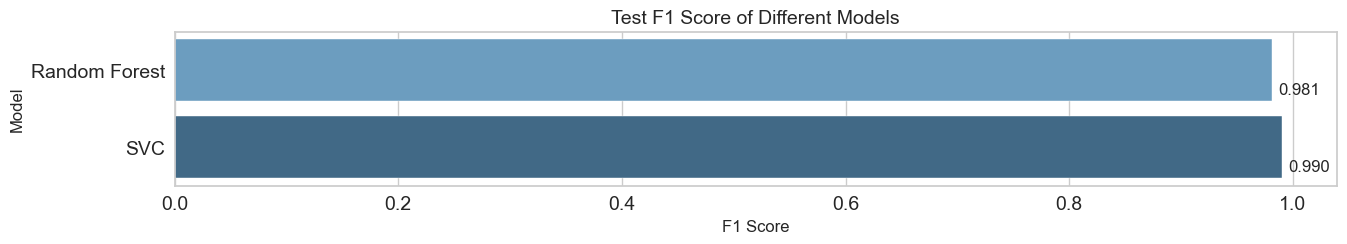

[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=180, n_estimators=50; total time=   1.1s
[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=200, n_estimators=50; total time=   1.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=200, n_estimators=100; total time=   2.1s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=180, n_estimators=100; total time=   4.6s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=200, n_estimators=100; total time=   4.6s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=200, n_estimators=50; total time=   1.2s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=200, n_estimators=100; total time=   2.3s
[CV] END criterion=entropy, max_depth=8, max_features=0.8, max_leaf_nodes=180, n_estimators=50; total time=   2.7s
[CV] END criterion=entropy, max_depth=8, max_features=0.8, max_leaf_nod

[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=180, n_estimators=50; total time=   1.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=180, n_estimators=100; total time=   2.0s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=180, n_estimators=50; total time=   2.2s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=180, n_estimators=100; total time=   4.3s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=200, n_estimators=100; total time=   4.5s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=200, n_estimators=50; total time=   1.1s
[CV] END criterion=entropy, max_depth=8, max_features=0.8, max_leaf_nodes=180, n_estimators=50; total time=   2.5s
[CV] END criterion=entropy, max_depth=8, max_features=0.8, max_leaf_nodes=180, n_estimators=100; total time=   5.2s
[CV] END criterion=entropy, max_depth=8, max_features=0.8, max_leaf_nodes

[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=180, n_estimators=50; total time=   1.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=200, n_estimators=50; total time=   1.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=200, n_estimators=100; total time=   2.0s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=180, n_estimators=50; total time=   2.2s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=200, n_estimators=50; total time=   2.2s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=200, n_estimators=100; total time=   4.4s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=180, n_estimators=100; total time=   2.3s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=200, n_estimators=100; total time=   2.2s
[CV] END criterion=entropy, max_depth=8, max_features=0.8, max_leaf_nod

[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=180, n_estimators=50; total time=   1.0s
[CV] END criterion=entropy, max_depth=7, max_features=auto, max_leaf_nodes=180, n_estimators=100; total time=   2.1s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=180, n_estimators=50; total time=   2.2s
[CV] END criterion=entropy, max_depth=7, max_features=0.8, max_leaf_nodes=180, n_estimators=100; total time=   4.4s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=180, n_estimators=50; total time=   1.1s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=180, n_estimators=50; total time=   1.1s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=180, n_estimators=100; total time=   2.2s
[CV] END criterion=entropy, max_depth=8, max_features=auto, max_leaf_nodes=200, n_estimators=50; total time=   1.2s
[CV] END criterion=entropy, max_depth=8, max_features=0.8, max_leaf_nod

In [65]:
compare = pd.DataFrame({"Model": ["SVC", "Random Forest"],
                        "F1 Score": [svm_f1_test, rfc_f1_test]})

compare = compare.sort_values(by="F1 Score", ascending=True)

plt.figure(figsize=(15,2))
ax = sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
for p in ax.patches:
    ax.annotate("%.3f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y() + .9),
                xytext=(5, 10), textcoords='offset points')

plt.yticks(size = 14)
plt.xticks(size = 14)
plt.title("Test F1 Score of Different Models", size=14);

# Conclusion